In [2]:
import ncar_jobqueue

In [3]:
cluster = ncar_jobqueue.NCARCluster(
#    cores=9,  # The number of cores you want
    memory='60GB',  # Amount of memory
#    processes=9,  # How many processes
    walltime='03:00:00',  # Amount of wall time
    project="ncgd0011",  #Project id
  
)

cluster.scale(16)

In [12]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

from etpac import annotate_stats
import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
#import pandas as pd
import xarray as xr
#import xgcm
import cartopy.crs as cr
from cartopy import feature as cf

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 300

xr.set_options(keep_attrs=True, display_style="html")

%watermark -iv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
dask         : 2021.6.0
matplotlib   : 3.5.3
ncar_jobqueue: 2021.4.14
xarray       : 0.18.2
pandas       : 1.4.4
sys          : 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
[GCC 9.3.0]
numpy        : 1.20.3
distributed  : 2021.6.0
cartopy      : 0.19.0.post1
json         : 2.0.9



In [6]:
client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.206.42:42590' processes=16 threads=32, memory=400.00 GiB>

In [7]:
files = '/glade/scratch/pmora/month_w_zi_0-30m.nc'

In [8]:
DS = xr.open_mfdataset(
    files,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
)
#[["so", "thetao", "uo", "vo", "wo"]]

In [9]:
DS

<xarray.Dataset>
Dimensions:  (month: 12, xh: 460, yh: 340, z_i: 13)
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * yh       (yh) float64 0.025 0.075 0.125 0.125 ... 16.82 16.88 16.93 16.93
  * z_i      (z_i) float64 0.0 2.5 5.0 7.5 10.0 ... 20.0 22.5 25.0 27.5 30.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    wo       (month, z_i, yh, xh) float32 dask.array<chunksize=(12, 13, 340, 460), meta=np.ndarray>

In [31]:
wo=DS["wo"]
wo

<xarray.DataArray 'wo' (month: 12, z_i: 13, yh: 340, xh: 460)>
dask.array<open_dataset-d0eb10f919557e8aec19a89ad3785108wo, shape=(12, 13, 340, 460), dtype=float32, chunksize=(12, 13, 340, 460), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * yh       (yh) float64 0.025 0.075 0.125 0.125 ... 16.82 16.88 16.93 16.93
  * z_i      (z_i) float64 0.0 2.5 5.0 7.5 10.0 ... 20.0 22.5 25.0 27.5 30.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Sea water Z velocity
    units:      m s-1

In [ ]:
wo = wo.isel(z_i=9)*86400 #at 20m depth
wo

In [32]:
wo20 = wo.isel(z_i=8)*86400 #at 20m depth
wo20

<xarray.DataArray 'wo' (month: 12, yh: 340, xh: 460)>
dask.array<mul, shape=(12, 340, 460), dtype=float64, chunksize=(12, 340, 460), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * yh       (yh) float64 0.025 0.075 0.125 0.125 ... 16.82 16.88 16.93 16.93
    z_i      float64 20.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Sea water Z velocity
    units:      m s-1

In [22]:
wo20 = DS['wo'].mean('z_i')*86400 #at 20m depth
wo20

<xarray.DataArray 'wo' (month: 12, yh: 340, xh: 460)>
dask.array<mul, shape=(12, 340, 460), dtype=float64, chunksize=(12, 340, 460), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * yh       (yh) float64 0.025 0.075 0.125 0.125 ... 16.82 16.88 16.93 16.93
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Sea water Z velocity
    units:      m s-1

In [ ]:
wo.plot.contourf(xh='lon',yh='lat',col='month',col_wrap=2)

<Figure size 1800x1200 with 0 Axes>

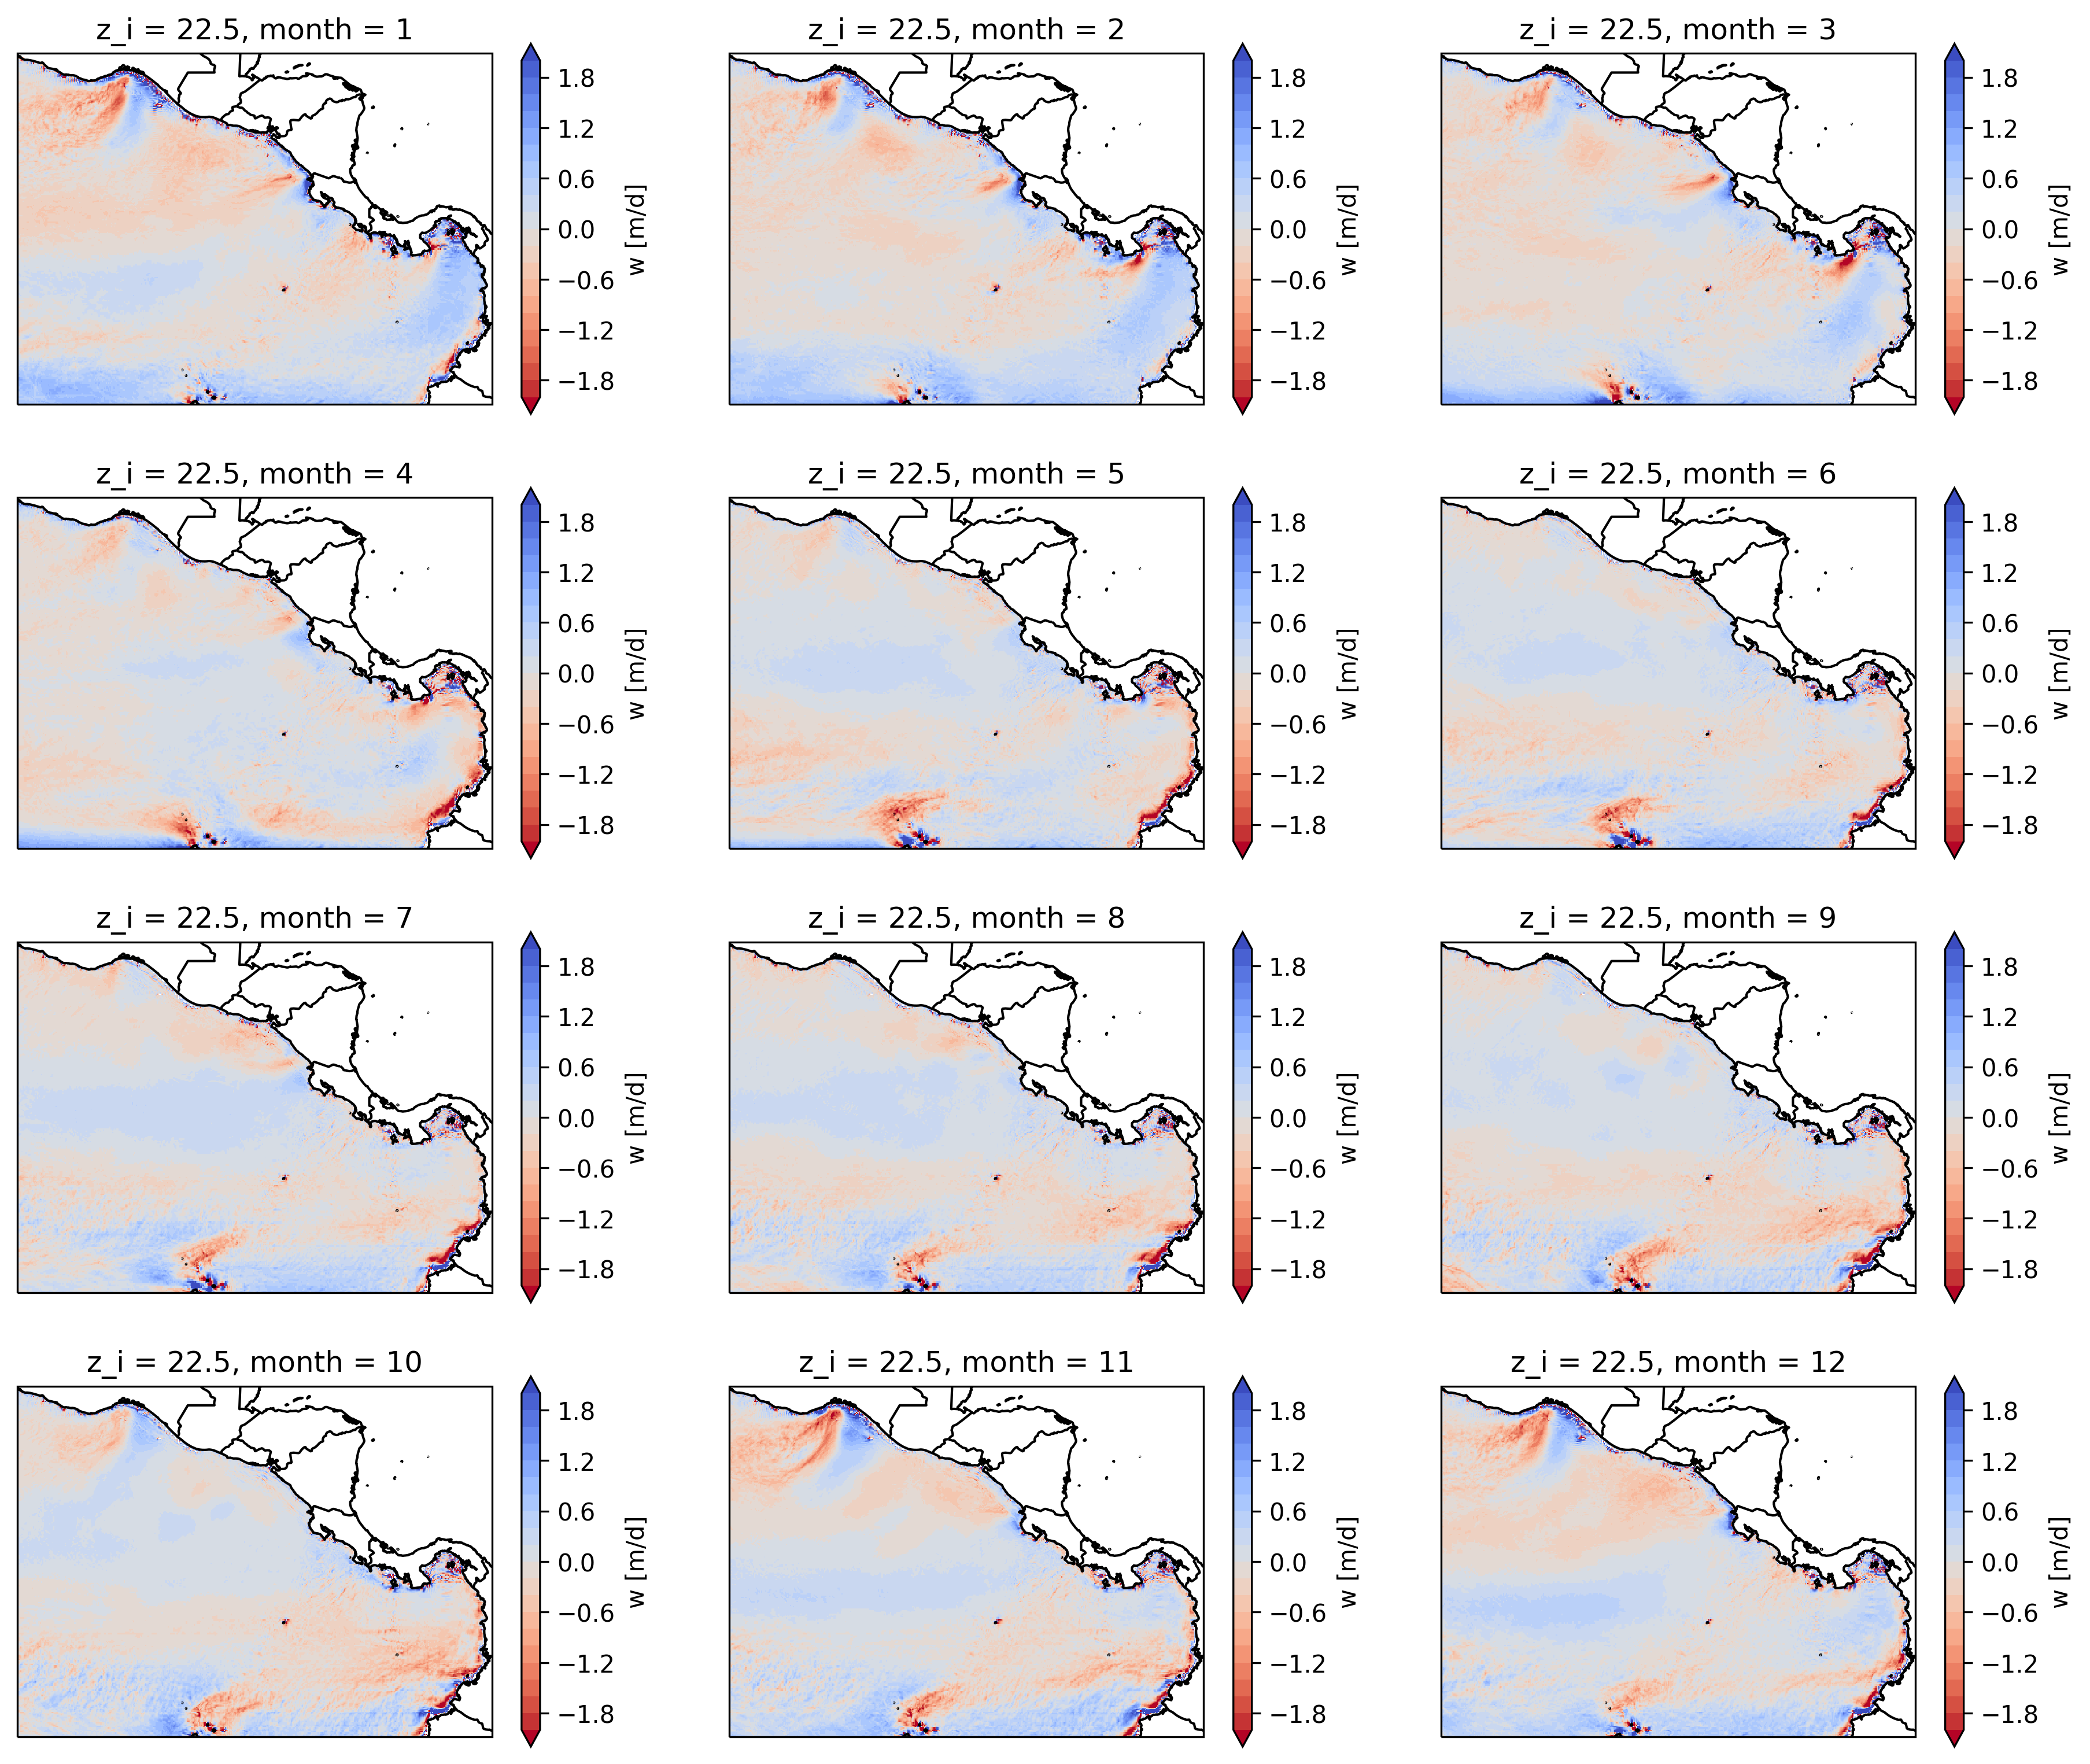

In [27]:
count = 0
plt.clf()
fig=plt.figure(figsize=(15,13))
fig.clear()
for mes in wo.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             wo[wo.month==mes].plot(vmin=-2,vmax=2, cmap="coolwarm_r", cbar_kwargs={"label": "w [m/d]"}, robust=True, levels=np.arange(-2.0,2.2,0.2))
#             annotate_stats(plt.gca(), wo[wo.month==mes])
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-100, -77, 0,17])

<Figure size 1800x1200 with 0 Axes>

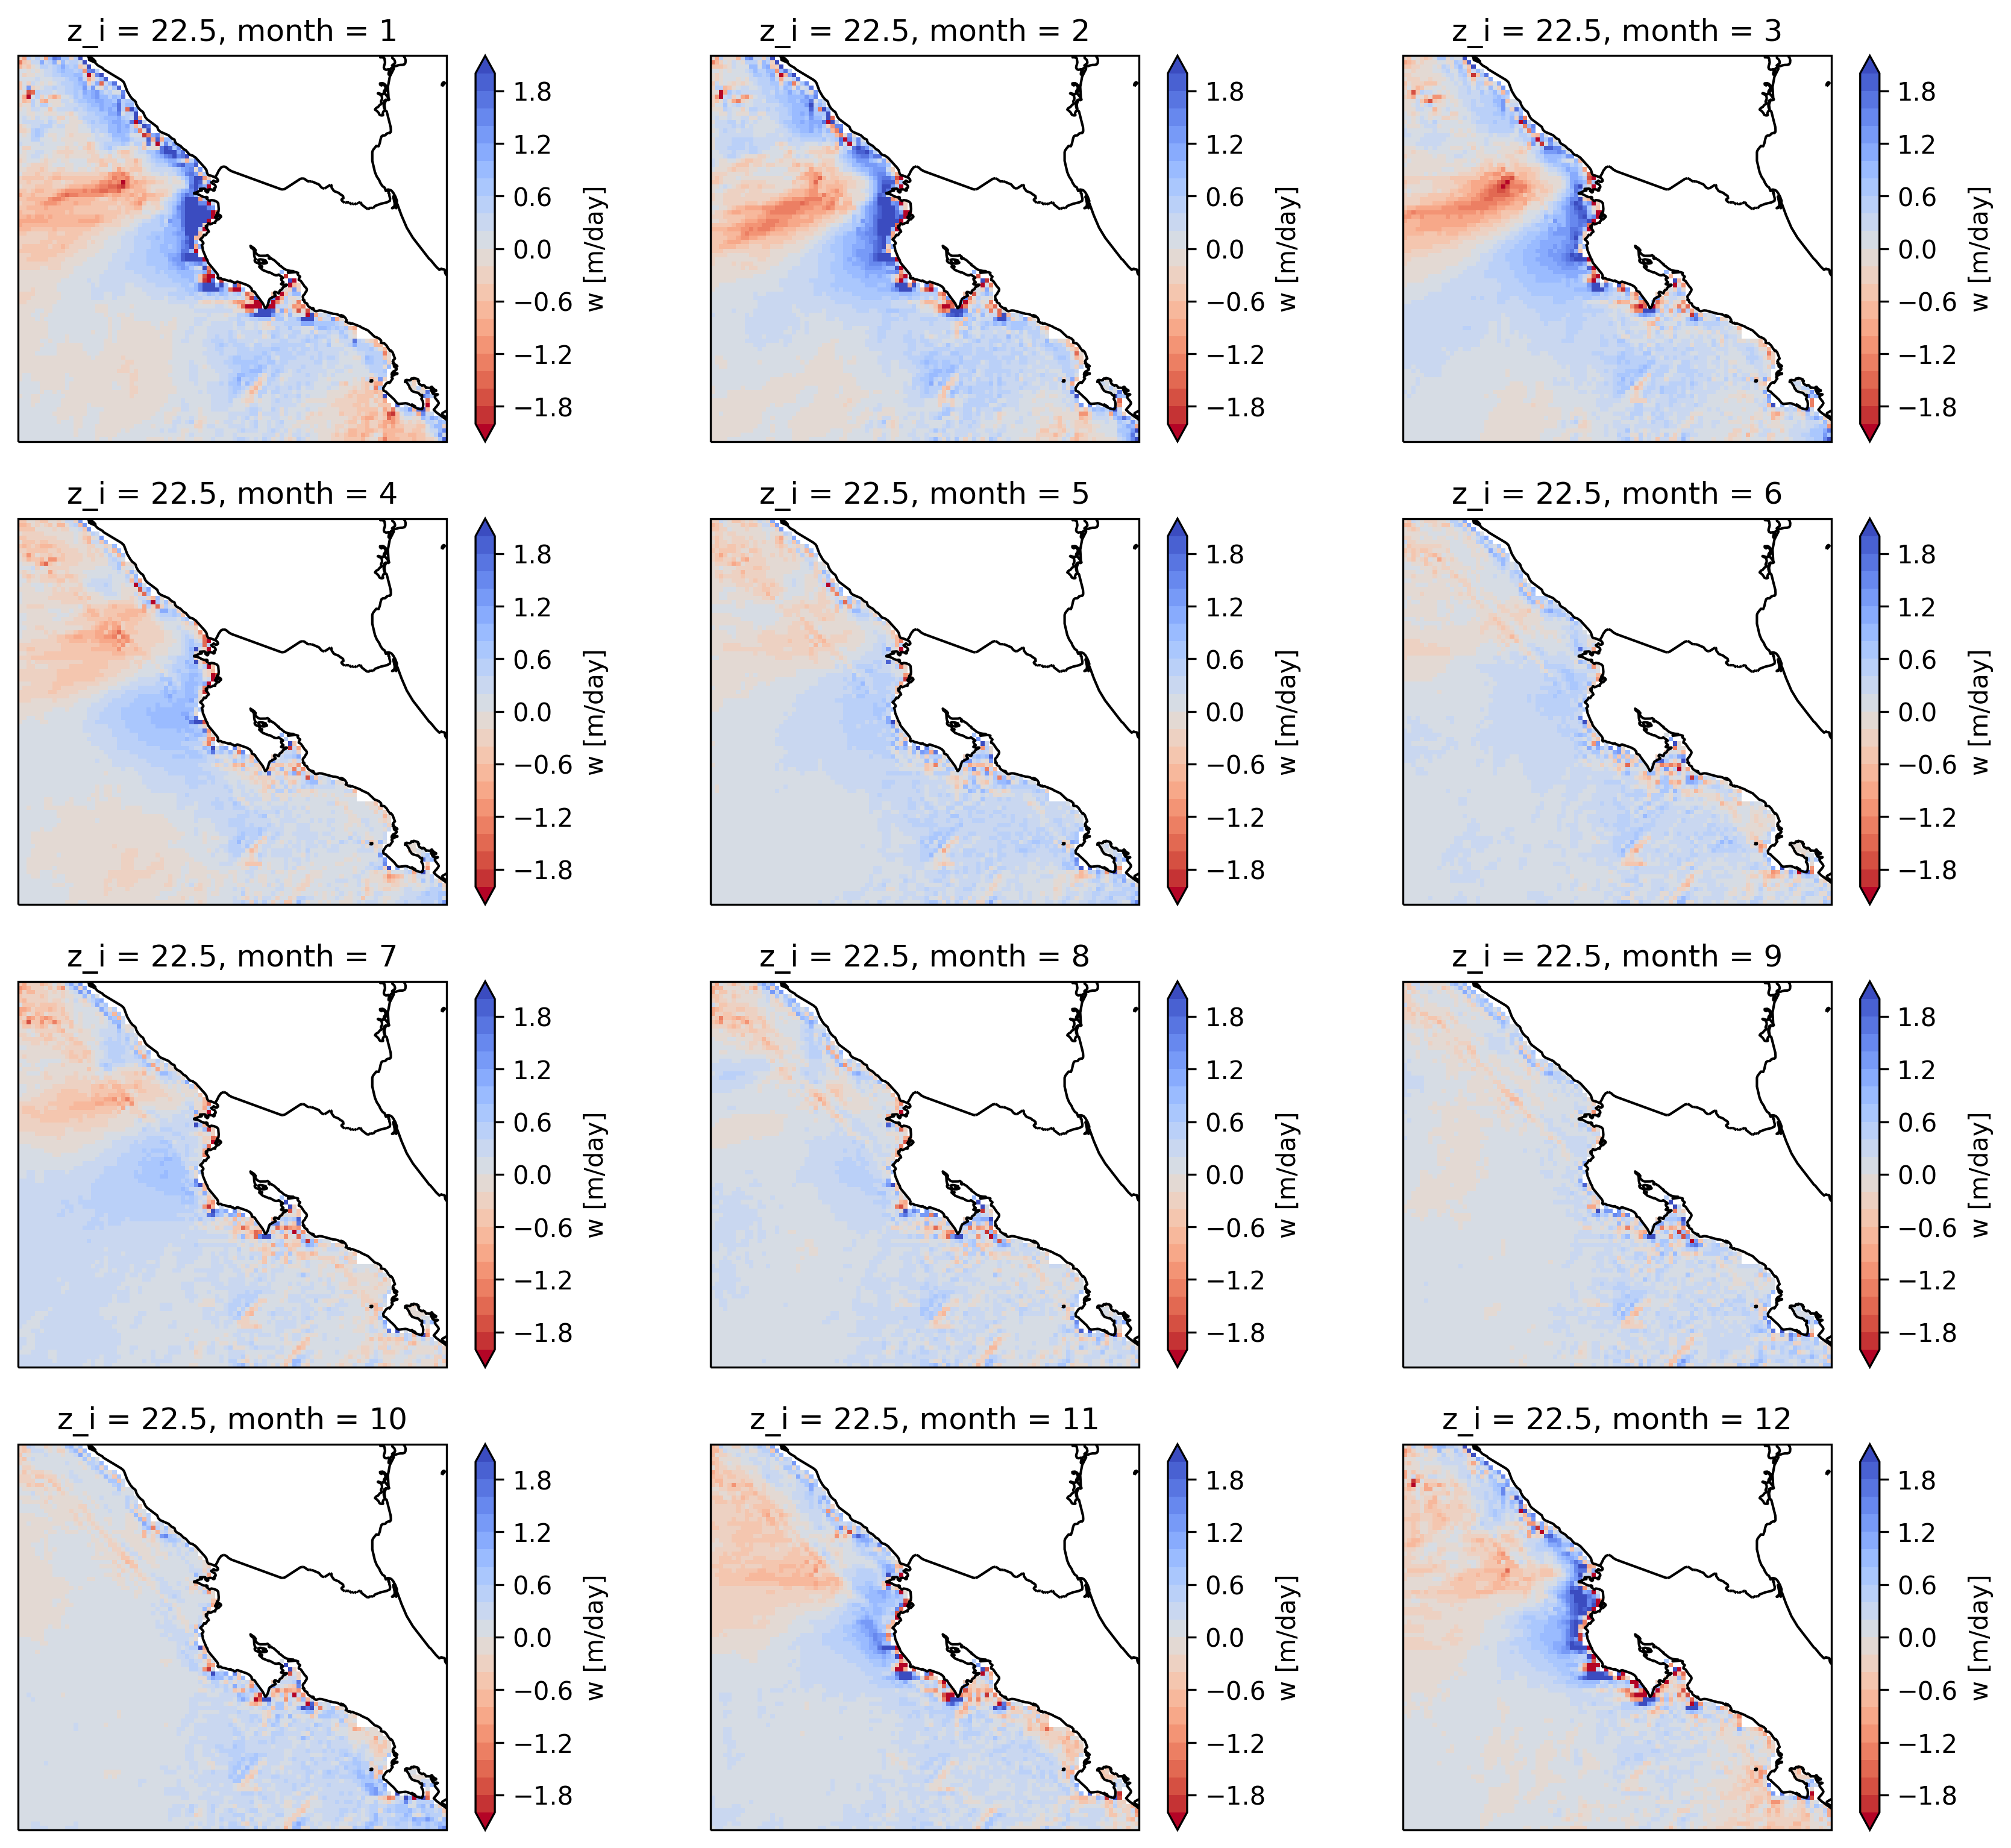

In [26]:
wo2 = wo.sel(xh=slice(272, 277), yh=slice(8, 13)) 
count = 0
plt.clf()
fig=plt.figure(figsize=(14,13))
for mes in wo2.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             wo2[wo2.month==mes].plot(vmin=-2,vmax=2, cmap="coolwarm_r", cbar_kwargs={"label": "w [m/day]"}, robust=True, levels =np.arange(-2,2.2,0.2))
#             annotate_stats(plt.gca(), wo2[wo2.month==mes])
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-88, -83, 8,12.5])

<Figure size 1800x1200 with 0 Axes>

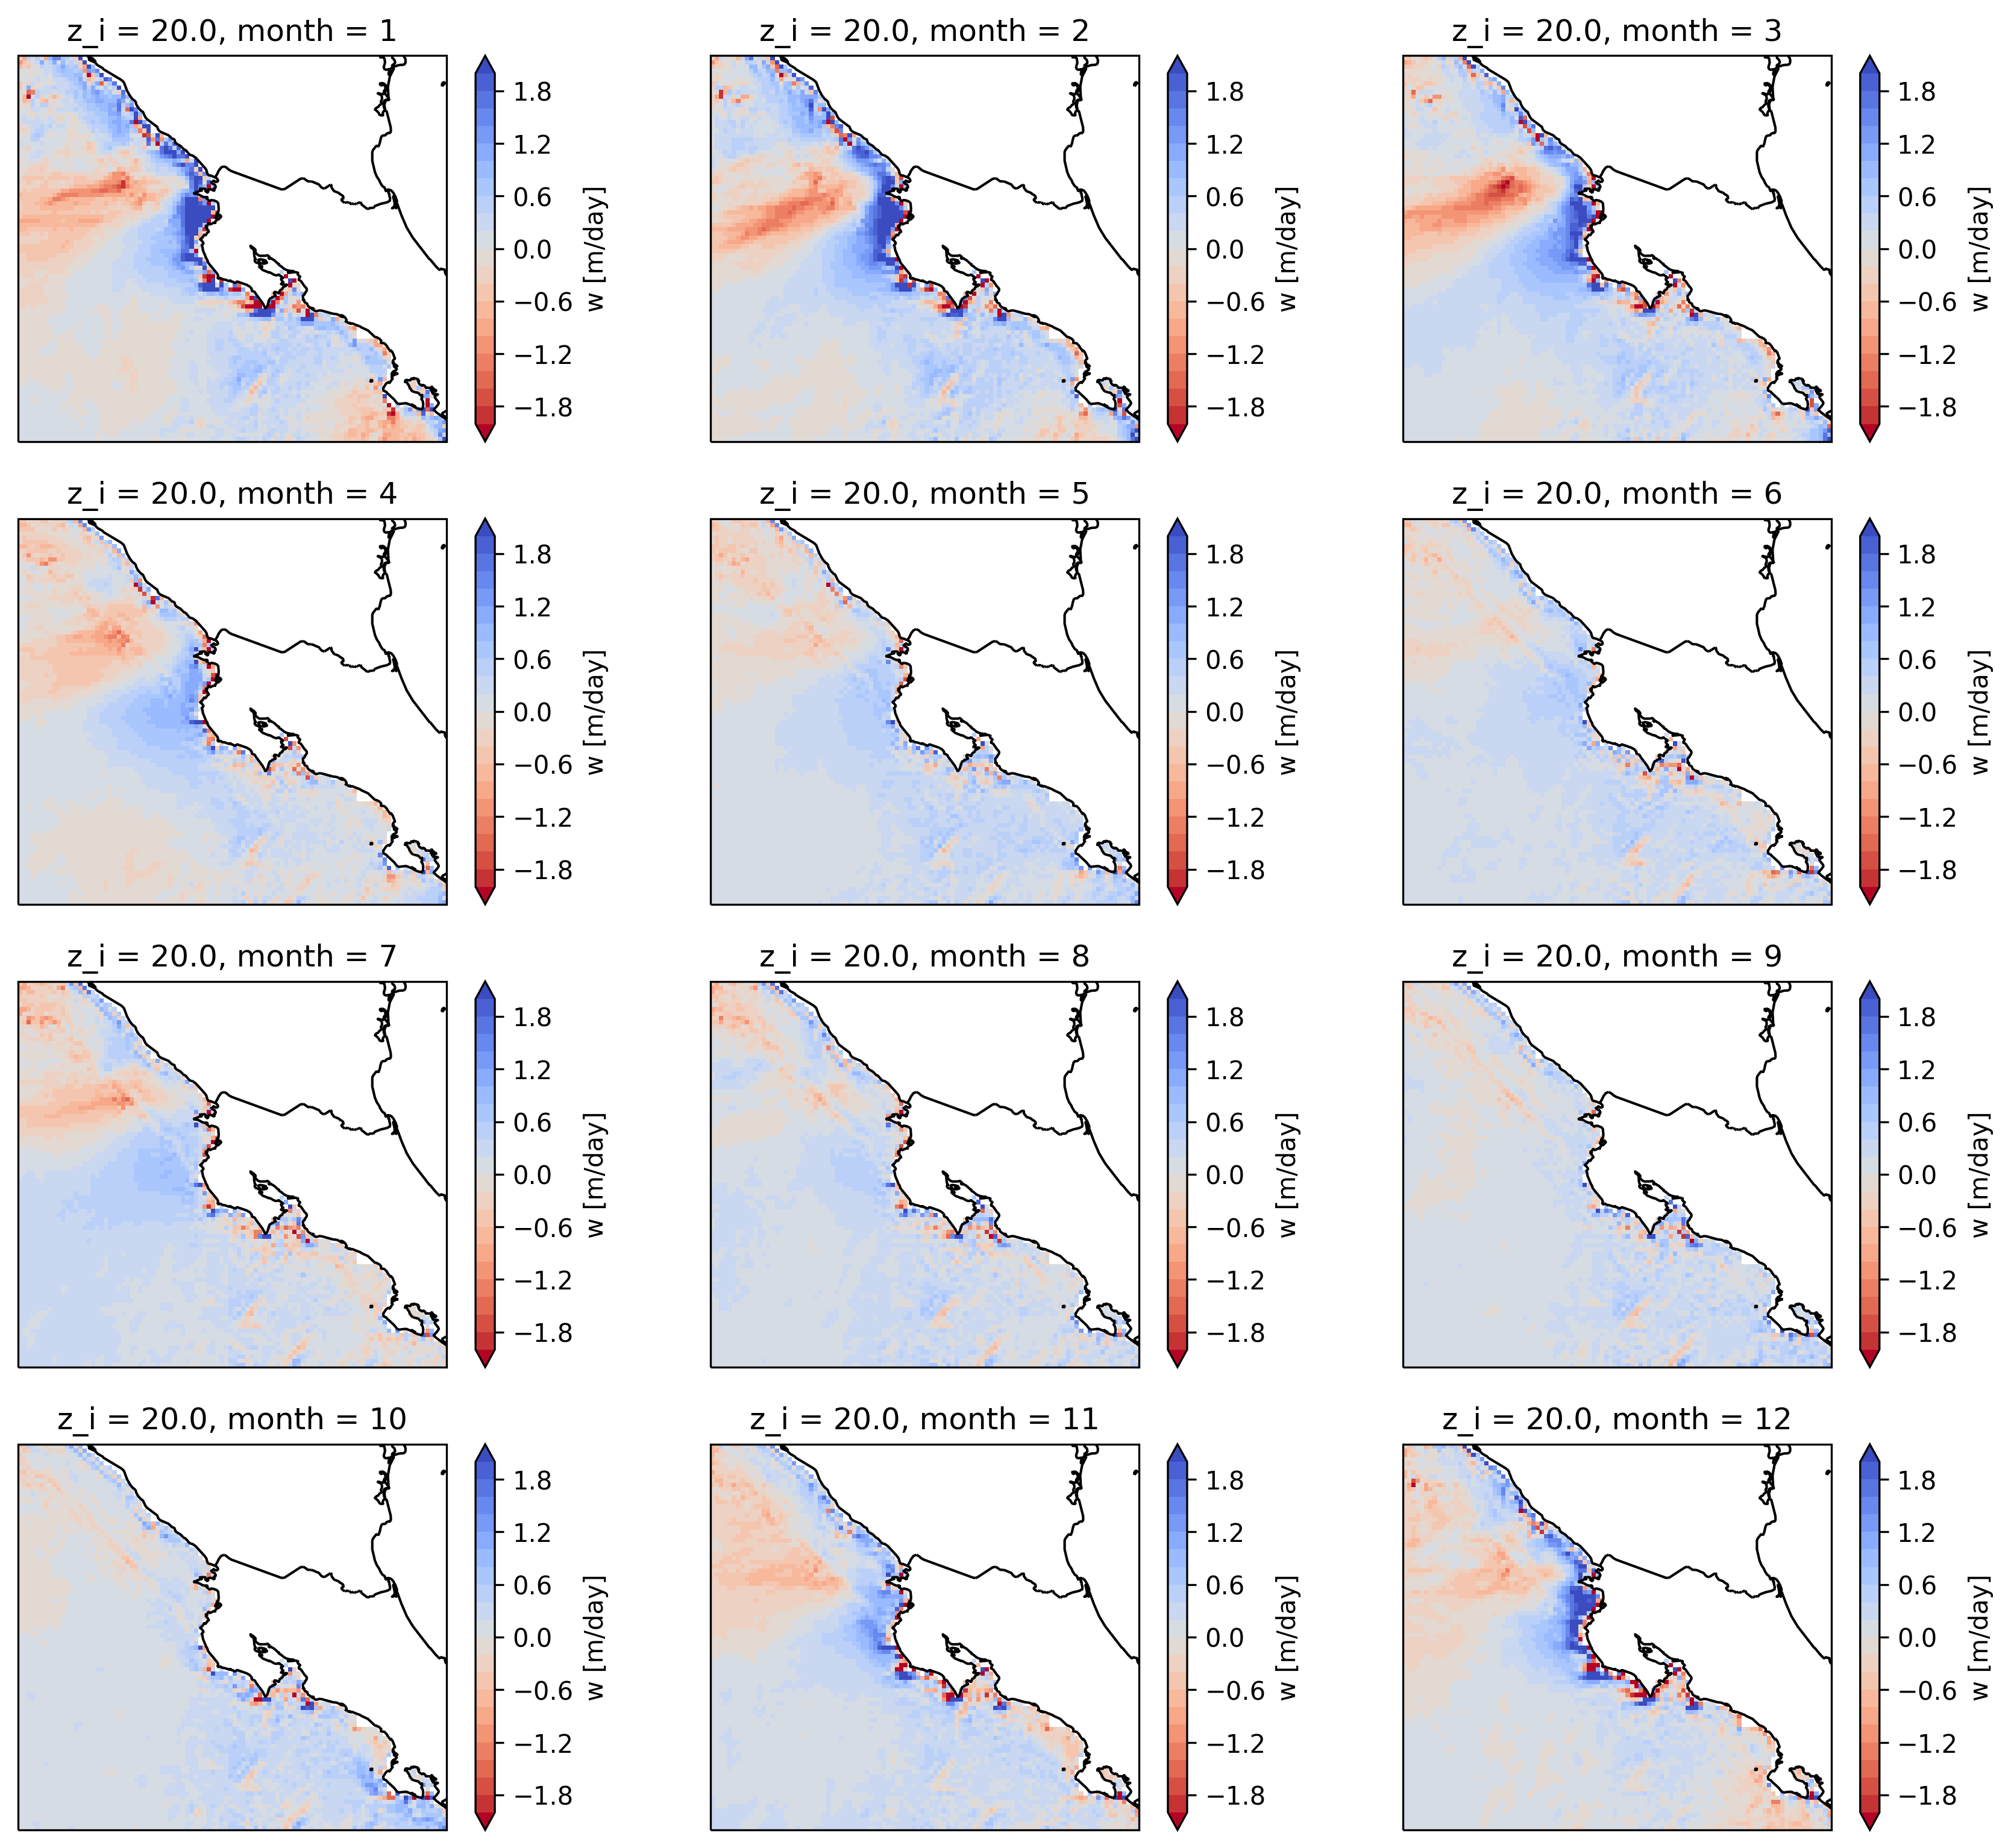

In [34]:
wo_2 = wo20.sel(xh=slice(272, 277), yh=slice(8, 13)) 
count = 0
plt.clf()
fig=plt.figure(figsize=(14,13))
for mes in wo_2.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             wo_2[wo_2.month==mes].plot(vmin=-2,vmax=2, cmap="coolwarm_r", cbar_kwargs={"label": "w [m/day]"}, robust=True, levels =np.arange(-2,2.2,0.2))
#             annotate_stats(plt.gca(), wo2[wo2.month==mes])
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-88, -83, 8,12.5])

In [35]:
client.close()
cluster.close()